In [1]:
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten, Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
img_rows = 28
img_cols = 28
channels = 1

img_shape = (img_rows, img_cols, channels)

z_dim = 100 #the size of noise vector

# build Generator

In this section we use LeakyReLU, because unless Relu makes the negative side to zero, LeakyReLU use the slight slope of negative side

In [3]:
def build_generator(img_shape, z_dim):
    model = Sequential()
    
    model.add(Dense(128, input_dim = z_dim))
    model.add(LeakyReLU(alpha = 0.01))
    model.add(Dense(28 * 28 * 1, activation = 'tanh'))
    model.add(Reshape(img_shape))
    
    return model

# build Discriminator

In [4]:
def build_discriminator(img_shape):
    model = Sequential()
    model.add(Flatten(input_shape = img_shape))
    model.add(Dense(128))
    model.add(LeakyReLU(alpha = 0.01))
    model.add(Dense(1, activation = 'sigmoid'))
    
    return model

In [5]:
def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    
    return model

discriminator = build_discriminator(img_shape)
discriminator.compile(loss = 'binary_crossentropy',
                      optimizer = Adam(),
                      metrics = ['accuracy'])

generator = build_generator(img_shape, z_dim)

discriminator.trainable = False

gan = build_gan(generator, discriminator)
gan.compile(loss = 'binary_crossentropy',
            optimizer = Adam())

In [6]:
losses = []
accuracies = []
iteration_checkpoint = []

def train(iterations, batch_size, sample_interval):
    
    (X_train,_), (_, _) = mnist.load_data()
    
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis= 3)
    
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for iteration in range(iterations):
        
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)
        
        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)
        
        g_loss = gan.train_on_batch(z, real)
        
        if (iteration + 1) % sample_interval == 0:
            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoint.append(iteration + 1)
            
            sample_images(generator)

In [9]:
def sample_images(generator, image_grid_rows = 4, image_grid_columns = 4):
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))
    
    gen_imgs = generator.predict(z)
    gen_imgs = 0.5 * gen_imgs + 0.5
    
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize = (4, 4),
                            sharey = True,
                            sharex = True)
    cnt = 0
    
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap = 'gray')
            axs[i, j].axis('off')
            cnt += 1

In [7]:
iterations = 10000
batch_size = 128
sample_interval = 1000

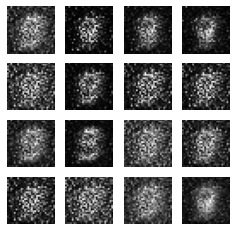

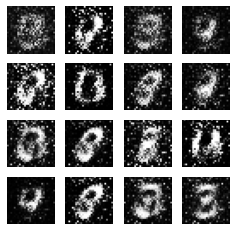

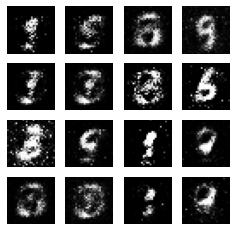

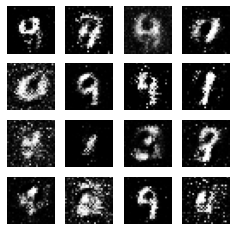

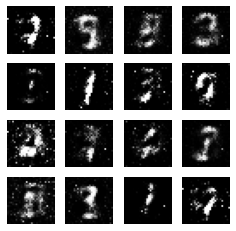

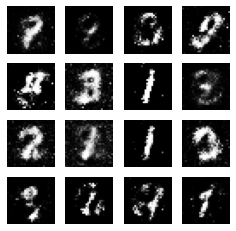

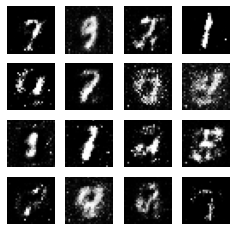

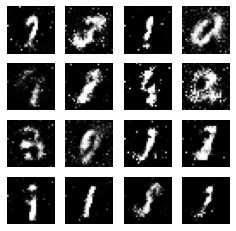

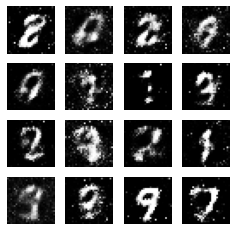

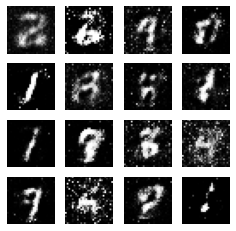

In [10]:
train(iterations, batch_size, sample_interval)